# BGR porovnání

In [37]:
from widgets.data import Data
import numpy as np
import scipy.signal
import scipy.interpolate as si
import matplotlib.pyplot as plt
from functools import reduce
from scipy.signal import argrelextrema

# Utils

In [86]:
def get_indices_range(x, start_value, end_value):
    start_index = np.argmin(np.absolute(x - start_value))
    end_index = np.argmin(np.absolute(x - end_value))
    return np.r_[start_index:end_index]

def get_indices_to_fit(x, ranges_to_ignore):
    union = reduce(np.union1d, (get_indices_range(x, *i) for i in ranges_to_ignore))
    to_fit = np.in1d(np.arange(x.shape[0]), union, invert=True)
    return to_fit

def plot(x, y, bg):

    fig = plt.figure(figsize=(25, 10))
    fig.add_subplot(1, 2, 1)

    # spectrum with BG
    plt.plot(x, y)
    plt.plot(x, bg, label="estimated background")
    plt.title("Spectrum with background")
    plt.legend()

    fig.add_subplot(1, 2, 2)

    # spectrum without BG
    plt.plot(x, y - bg - np.min(y - bg))
    plt.ylim(0, 100)
    plt.title("Spectrum without background")

    plt.tight_layout()
    plt.show()

# MM

In [76]:
def erosion(values: np.ndarray, window_width: int) -> np.ndarray: # start with 1 (structuring element has then size 3 (2 * w_w + 1))
    # eroze -> minmum v okně
    padded_values = np.pad(values, (window_width, window_width), 'constant', constant_values=(values[0], values[-1])) # pad with side values from sides
    windows = np.lib.stride_tricks.sliding_window_view(padded_values, 2 * window_width + 1)
    mins = np.min(windows, axis=1)
    return mins

def dilation(values: np.ndarray, window_width: int) -> np.ndarray:
    # dilatace -> maximum v okně
    padded_values = np.pad(values, (window_width, window_width), 'constant', constant_values=(values[0], values[-1])) # pad with side values from sides
    windows = np.lib.stride_tricks.sliding_window_view(padded_values, 2 * window_width + 1)
    mins = np.max(windows, axis=1)
    return mins

def opening(values: np.ndarray, window_width: int) -> np.ndarray:
    return dilation(erosion(values, window_width), window_width)

def closing(values: np.ndarray, window_width: int) -> np.ndarray:
    return erosion(dilation(values, window_width), window_width)

def top_hat(values: np.ndarray, window_width: int) -> np.ndarray:
    return values - opening(values, window_width)

def get_optimal_structuring_element_width(values : np.ndarray) -> int:
    max_sim_counter = 3 # zmena oproti navrhovanemu algoritmu, potrebujeme vice (4 nebo 5 se zda byt ok)
    window_width = 1
    opened_array = opening(y, window_width)

    while True:
        window_width += 1
        new_opened_array = opening(opened_array, window_width)
        if np.any(new_opened_array != opened_array):
            similarity_counter = 0
            opened_array = new_opened_array
            continue
        else:
            similarity_counter += 1
            if similarity_counter == max_sim_counter:
                return window_width - max_sim_counter + 1 # restore window width of the first similar result

def mm_algo(x, y, ignore_water=False):
    if ignore_water:
        water_start_index = np.argmin(np.abs(x - 2950))
        water_part_y = y[water_start_index:]
        window_water = int(np.round(len(water_part_y) / 2))
        spectrum_opening = opening(water_part_y, window_water)
        approximation = np.mean(erosion(spectrum_opening, window_water) + dilation(spectrum_opening, window_water), axis=0)
        background_water = np.minimum(spectrum_opening, approximation)

        not_water_part_y = y[:water_start_index]
        window_width = get_optimal_structuring_element_width(not_water_part_y)
        spectrum_opening = opening(not_water_part_y, window_width)
        approximation = np.mean(erosion(spectrum_opening, window_width) + dilation(spectrum_opening, window_width), axis=0)
        background_not_water = np.minimum(spectrum_opening, approximation)
        background = np.concatenate((background_not_water, background_water))
        return background

    window_width = get_optimal_structuring_element_width(y)

    # print(f"Optimal window size: {2 * window_width + 1}")
    spectrum_opening = opening(y, window_width)
    approximation = np.mean(erosion(spectrum_opening, window_width) + dilation(spectrum_opening, window_width), axis=0)
    background = np.minimum(spectrum_opening, approximation)

    # no_baseline_spectrum = y - background # top hat with computed value
    return background

# EMD + VRA + mVRA

In [90]:
def emd_step(x, y):

    min = argrelextrema(y, np.less)
    min_indices = np.unique(np.append(np.insert(min[0], 0, 0), len(x)-1))
    min_spline = si.CubicSpline(x[min_indices], y[min_indices], extrapolate=True)
    lower_envelope = min_spline(x)

    max = argrelextrema(y, np.greater)
    max_indices = np.unique(np.append(np.insert(max[0], 0, 0), len(x)-1))
    max_spline = si.CubicSpline(x[max_indices], y[max_indices], extrapolate=True)
    upper_envelope = max_spline(x)
    env_mean = (upper_envelope + lower_envelope) / 2

    return y - env_mean # h

def EMD(x, y, th=0.01):
    H = []
    R = [] # residua

    prev_h = y
    r = y
    while True:
        h = emd_step(x, prev_h)
        SD = np.sum((np.abs(prev_h - h)**2) / (prev_h**2 + 0.0001))

        if SD < th:
            H.append(h)
            r = r - h
            prev_h = r
            R.append(r)
            
            mins = argrelextrema(r, np.less)[0]
            maxes = argrelextrema(r, np.greater)[0]

            # new residuum is monotonic or has noly one extrema
            if np.all(np.diff(r) >= 0) or np.all(np.diff(r) <= 0) or (len(mins) + len(maxes) <= 1):
                return H, R[-1]
            continue
        prev_h = h

def vancouver(x, y, degree):
    signal = y
    first_iter = True
    devs = [0]
    criterium = np.inf
    while criterium > 0.05:
        obj = np.polynomial.Polynomial(None).fit(x, signal, deg=degree)
        poly = obj(x)
        residual = signal - poly
        residual_mean = np.mean(residual)
        DEV = np.sqrt(np.mean((residual - residual_mean)**2))
        devs.append(DEV)
        
        if first_iter:
            # remove peaks from fitting in first iteration
            not_peak_indices = np.where(signal <= (poly + DEV))
            signal = signal[not_peak_indices]
            x = x[not_peak_indices]
            first_iter = False
        else:
        # reconstruction
            signal = np.where(signal < poly + DEV, signal, poly + DEV)
        criterium = np.abs((DEV - devs[-2]) / DEV)
    return obj

def mVRA(x, y):
    H, R = EMD(x, y)
    denoised = y - np.sum(H[:1], axis=0)
    f = R + H[-1] # fluorescence estimation form EMD

    # continue - fluorescence estimation
    poly = None
    final_deg = None
    for degree in range(1, 16):
        poly = np.polynomial.Polynomial(None).fit(x, f, deg=degree)(x)
        correlation = scipy.stats.spearmanr(poly, f).correlation
        if correlation >= 0.99:
            final_deg = degree
            break

    e = []
    for degree in range(final_deg + 1, 16):
        new_poly = np.polynomial.Polynomial(None).fit(x, f, deg=degree)(x)
        RMSE = np.sqrt(np.mean(np.sum((poly - new_poly)**2, axis=0)))
        poly = new_poly
        e.append(RMSE)
    
    d = final_deg + np.argmin(e)
    print(d)
    bg = vancouver(x, denoised, d)
    return bg

# Tests

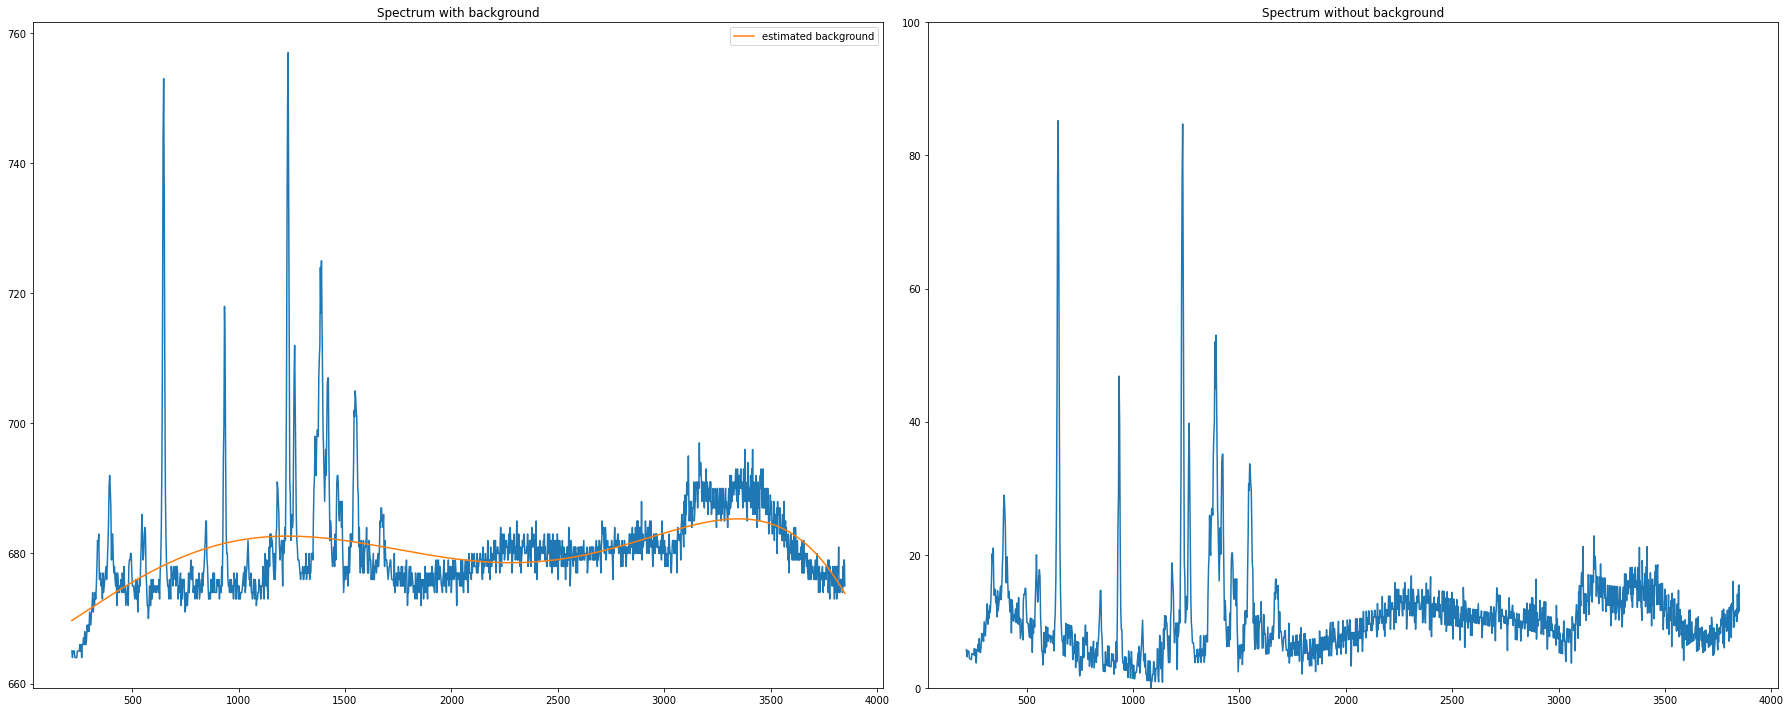

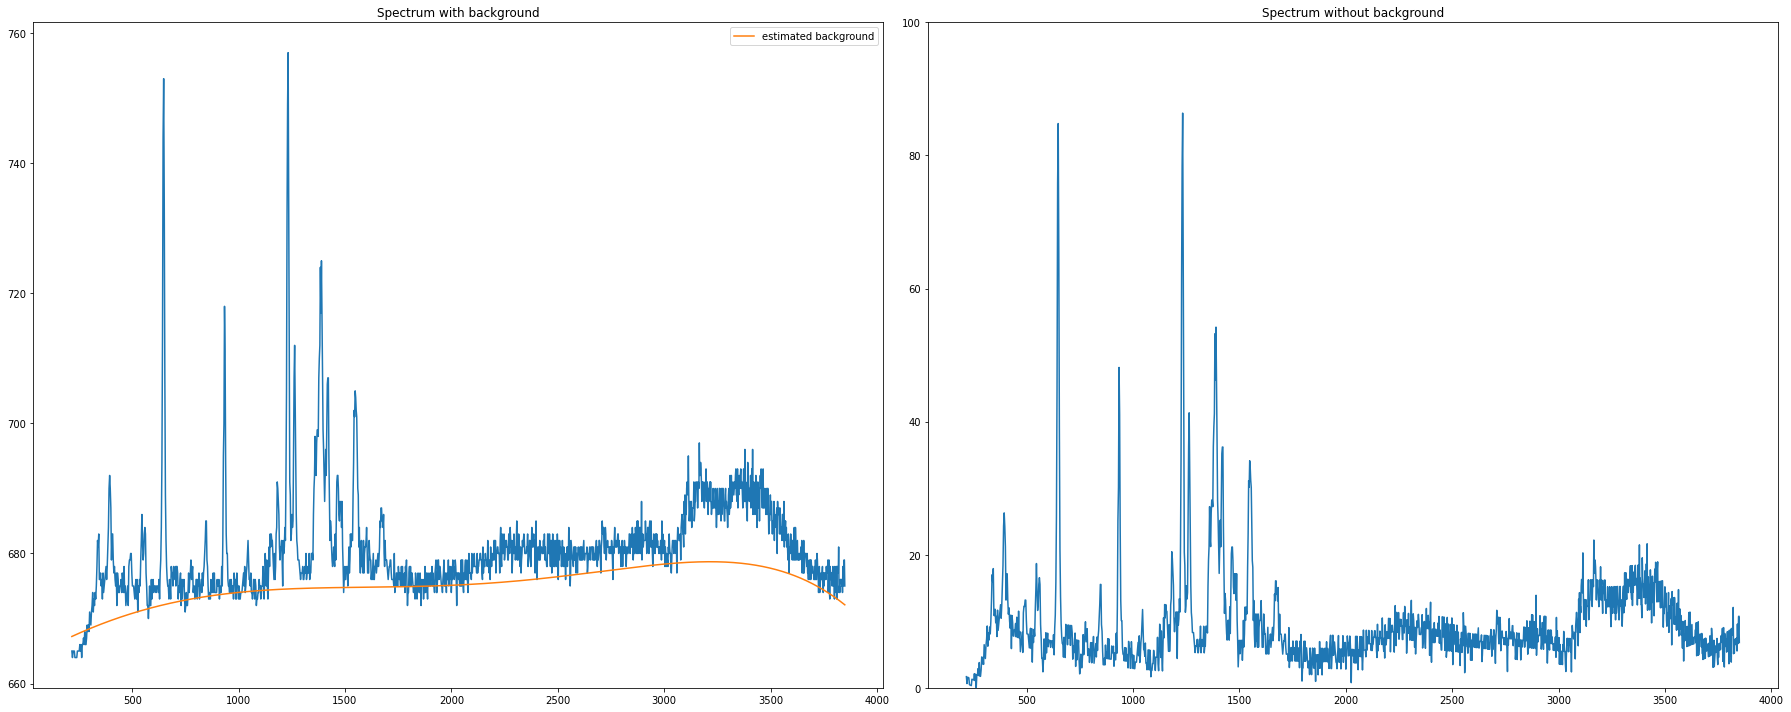

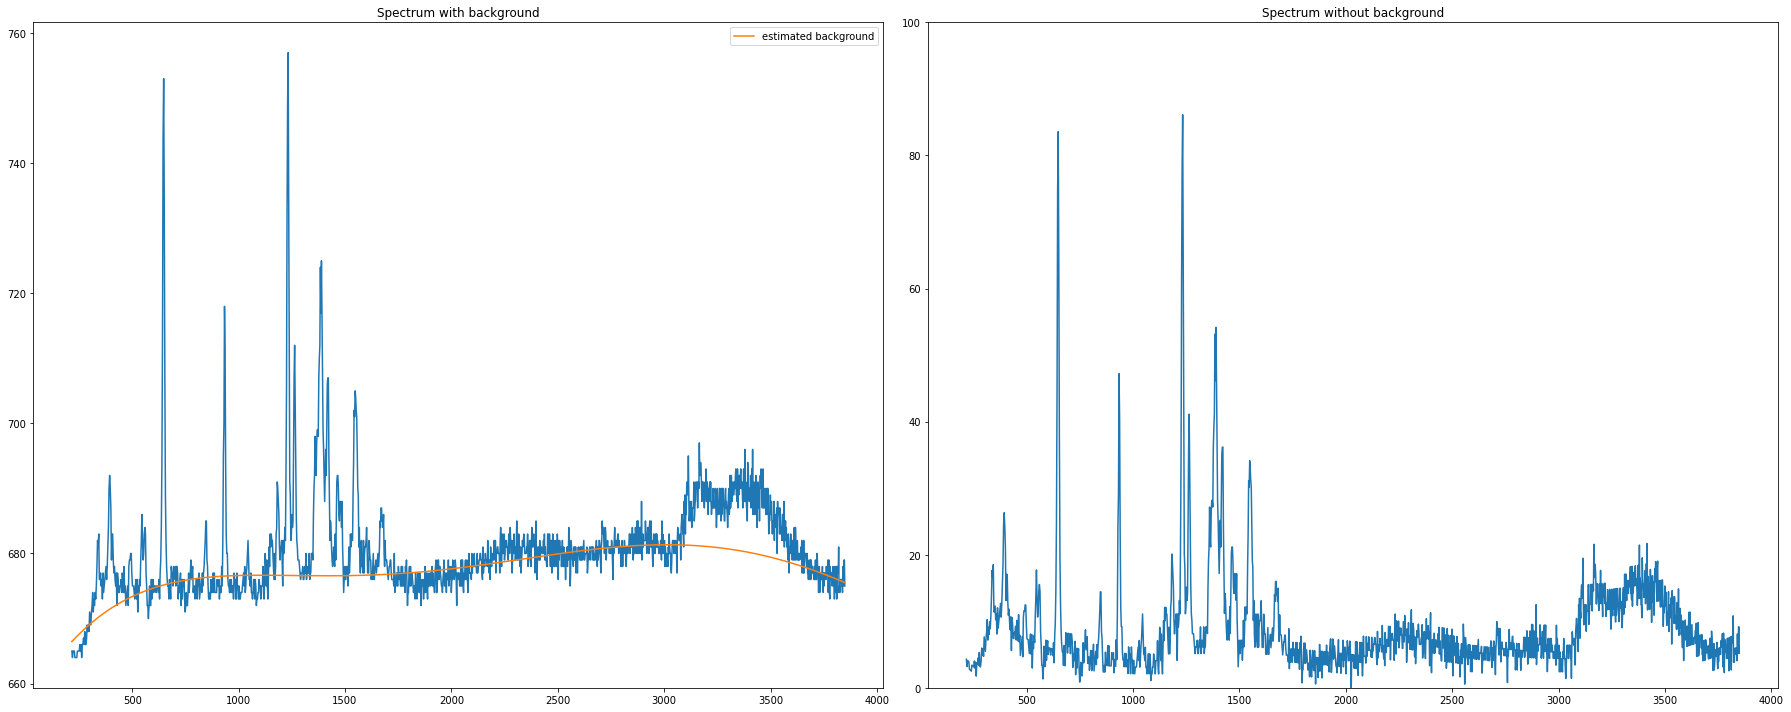

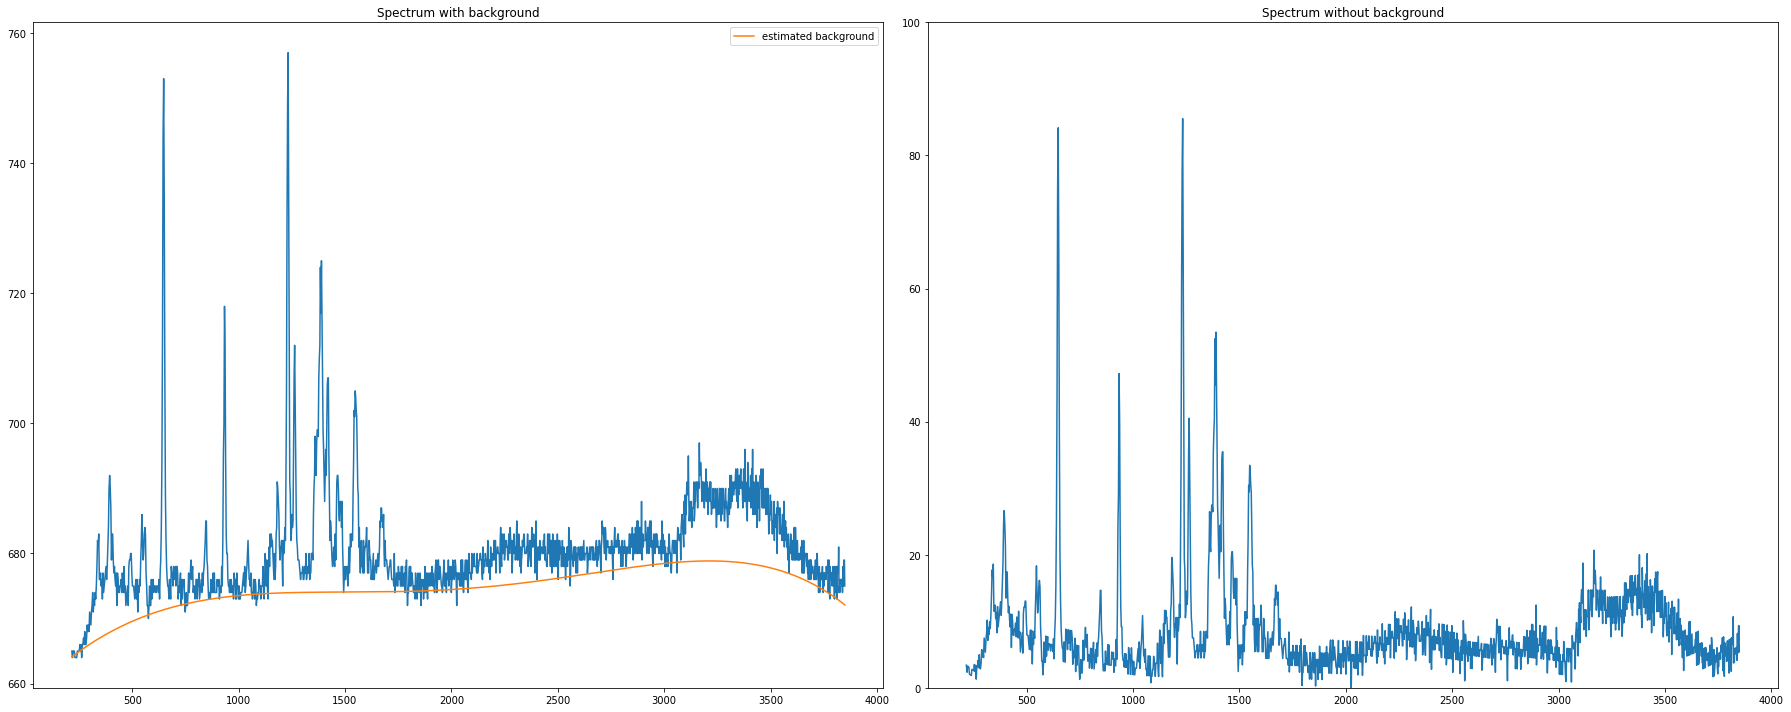

3


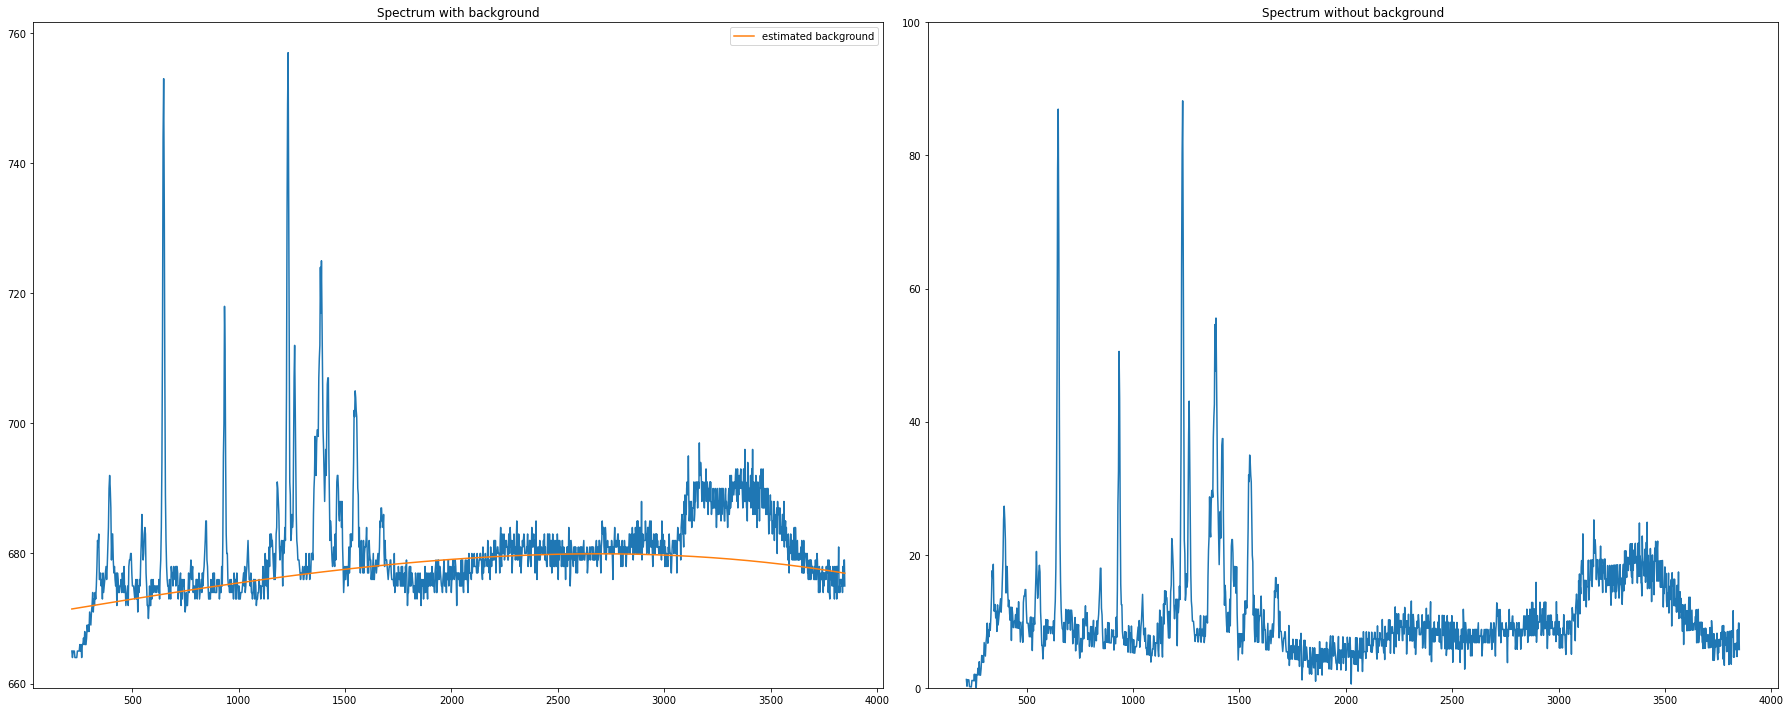

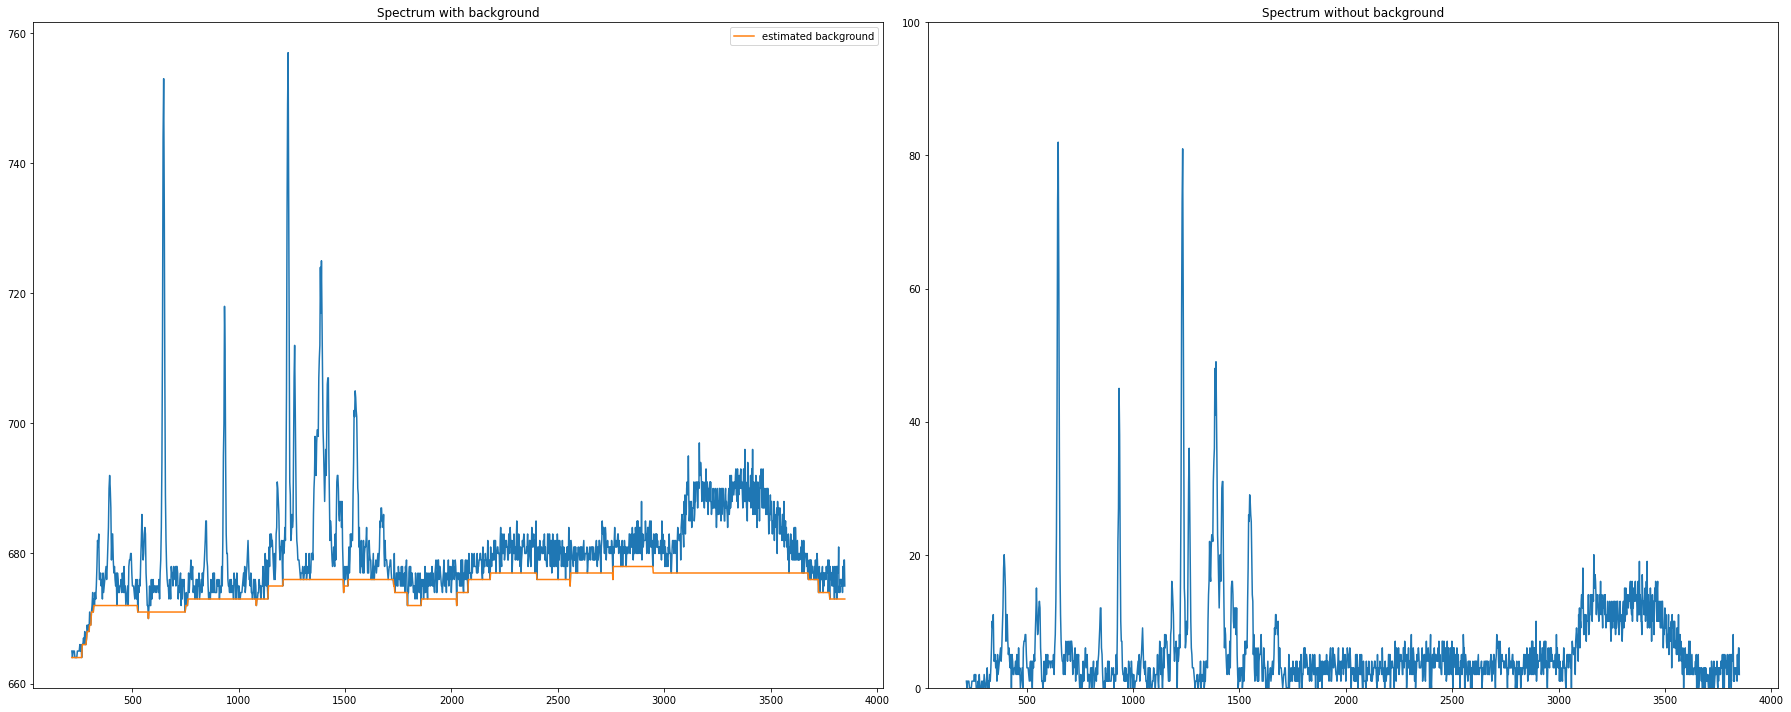

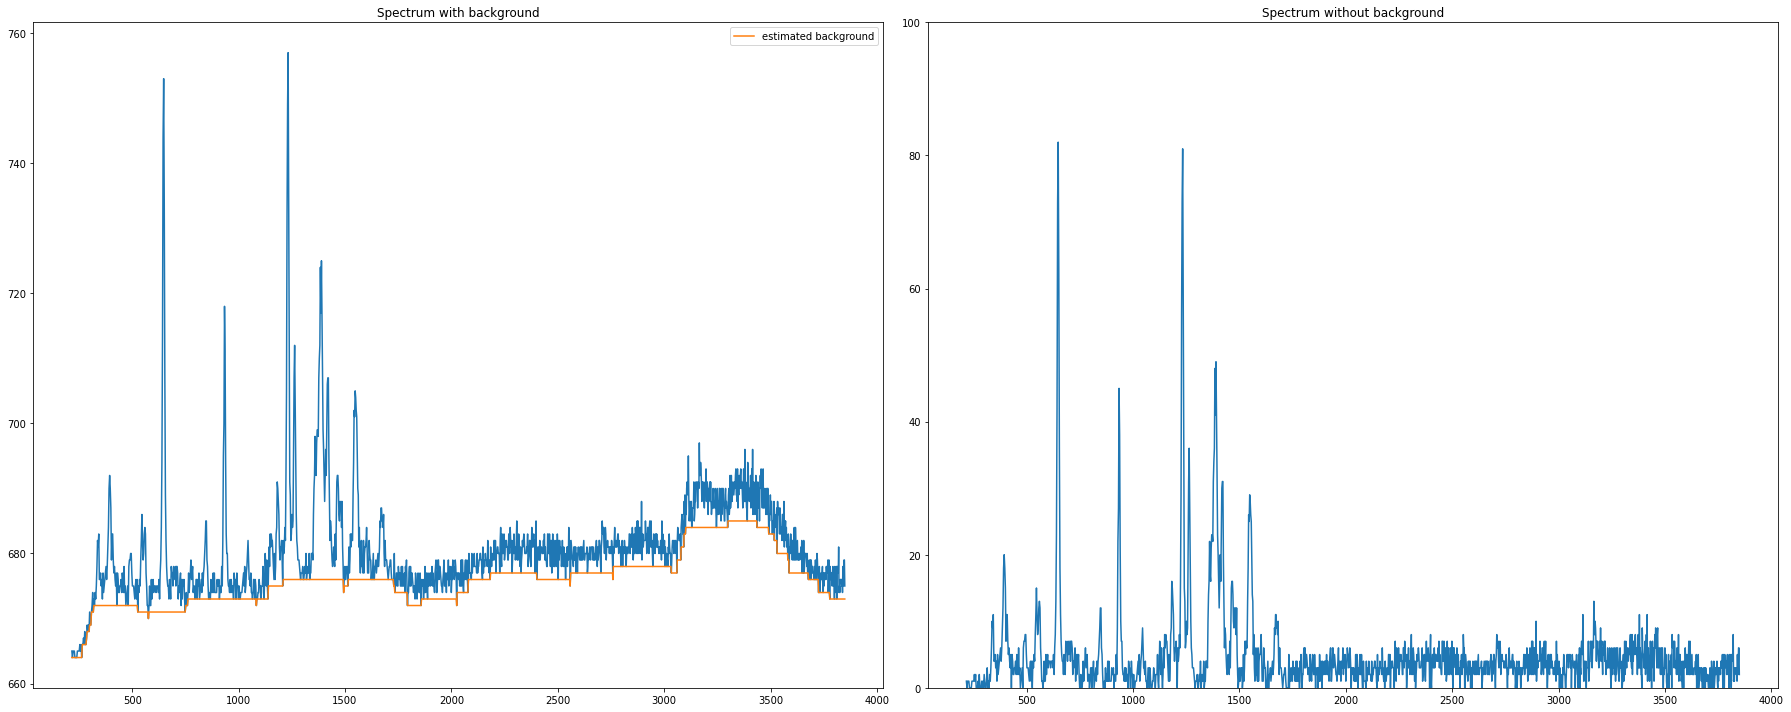

In [91]:
# data = Data("./data/Cryptomonas.mat")
data = Data("./data/Bigelowiella.mat")
x = data.x_axis
y = data.data[27, 15, :] # 30, 8 (crypto), 27, 15 (bigel)
to_ignore = [[3000, 3750]]
to_fit = get_indices_to_fit(x, to_ignore)


opt_ww = get_optimal_structuring_element_width(y[get_indices_range(x, 500, 3000)])
spectrum_opening = opening(y, opt_ww)
approximation = np.mean(erosion(spectrum_opening, opt_ww) + dilation(spectrum_opening, opt_ww), axis=0)
background_op = np.minimum(spectrum_opening, approximation)

# poly
poly_bg = np.polynomial.Polynomial(None).fit(x[to_fit], y[to_fit], deg=5)(x)
plot(x, y, poly_bg)

poly_bg_op = np.polynomial.Polynomial(None).fit(x[to_fit], background_op[to_fit], deg=5)(x)
plot(x, y, poly_bg_op)


# VRA
vra_bg = vancouver(x[to_fit], y[to_fit], 5)
plot(x, y, vra_bg(x))

vra_bg_op = vancouver(x[to_fit], background_op[to_fit], 5)
plot(x, y, vra_bg_op(x))


# mVRA

mvra_bg = mVRA(x[to_fit], y[to_fit])
plot(x,y, mvra_bg(x))

# MM
mm_bg = mm_algo(x, y, True)
plot(x, y, mm_bg)

# co bylo posledne poslano
mm_bg_w = mm_algo(x, y)
plot(x,y,mm_bg_w)



